In [599]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from scipy.spatial.distance import pdist
import torch.optim as optim

from matplotlib.lines import Line2D  # Import Line2D for custom legend

from torch.optim.lr_scheduler import ReduceLROnPlateau


from utils import *

We moved all the useful functions from the previous assignments to a separate file utils.py. You can simply import them with the following line. Feel free to add additional functions or modify the existing ones!

In [600]:
from utils import MLP, split_data, Dataset, train

In [601]:
# check if a GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [602]:
molecule = np.array(
    [
        [0.702581, 1.820873],
        [0.702581, 0.296325],
        [-0.702581, -0.296325],
        [-0.702581, -1.820873],
    ]
)

n_atoms = molecule.shape[0]
n_dimensions = molecule.shape[1]

print(
    f"Number of particles: {n_atoms} \nNumber of spatial dimensions: {n_dimensions}",
)

Number of particles: 4 
Number of spatial dimensions: 2


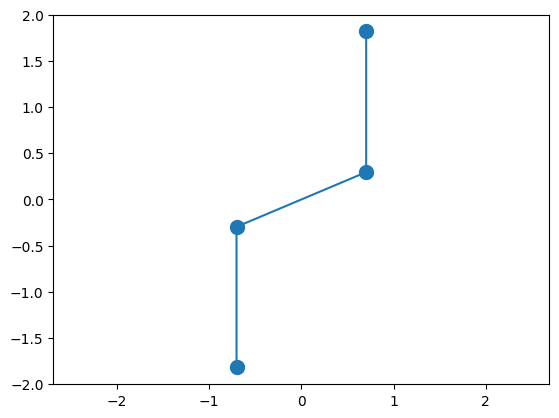

In [603]:
plt.plot(molecule[:, 0], molecule[:, 1], "o-", markersize=10)
plt.axis("equal")

plt.show()

In [ ]:
n_samples = 5000
mean = 0
standard_dev = 0.1
noise = np.random.normal(
                 size=(n_samples, n_atoms, n_dimensions),
                 loc=mean, 
                 scale = standard_dev,
)

noised_molecules = noise + molecule
noised_molecules

array([[[ 0.39399728,  0.55279292],
        [ 1.21366477,  1.06633774],
        [-1.32133857,  0.82586164],
        [-1.24487439, -1.82709296]],

       [[ 0.5326348 ,  1.60688805],
        [ 2.44874476,  0.49157636],
        [-2.35660123, -0.57953377],
        [-0.68723388, -0.95976595]],

       [[ 0.98914038,  2.15996914],
        [-0.37886175, -0.72691648],
        [-1.02914744, -1.00236449],
        [-0.50230942, -2.17940266]],

       ...,

       [[ 1.0200242 ,  3.68564307],
        [ 0.59877541,  1.93529707],
        [-1.80049573,  0.52581994],
        [-1.04396953, -3.30908657]],

       [[ 1.64769941,  0.82458003],
        [ 0.05357032,  1.64136051],
        [-0.42812673, -0.88250514],
        [-0.4348776 , -2.26934285]],

       [[ 1.04366961,  3.0680538 ],
        [ 1.16770871,  1.94434623],
        [-2.01568355,  0.98954279],
        [-1.00116428, -2.34603798]]])

In [605]:
def plot_mollies(mollies, title="Molecules with Noise"):
  labeled = False
  alpha = 50 / n_samples
  for mol in mollies:
    mol = np.array(mol)
    if not labeled:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha, 
              label=f"Probability cloud of molecule with: \n\t{n_samples} samples, \n\tmean: {mean}, \n\tstandard deviation: {standard_dev}")
      labeled = True
    else:
      plt.plot(mol[:, 0], mol[:, 1], "o-", markersize=10, c="Blue", alpha=alpha)

  legend_handle = Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', markersize=10, alpha=.5)  # Higher alpha for legend

  plt.axis("equal")
  plt.xlabel("X")
  plt.ylabel("Y")
  plt.title("Molecule with Noise")

  plt.legend([legend_handle], [f"Probability cloud of molecule with \n{n_samples} samples, \nmean: {mean}, \nstandard deviation: {standard_dev}"])


  plt.tight_layout()
  plt.show()

# def plot_dataset(my_dataset, title="Molecules with Noise"):
#     # mollies = [my_dataset[i][0].tolist() for i in range(len(my_dataset)) ]
#     # alpha = 50 / n_samples
#     print(mollies)
#     plot_mollies(mollies, title)



In [606]:
noised_molecules

array([[[ 0.39399728,  0.55279292],
        [ 1.21366477,  1.06633774],
        [-1.32133857,  0.82586164],
        [-1.24487439, -1.82709296]],

       [[ 0.5326348 ,  1.60688805],
        [ 2.44874476,  0.49157636],
        [-2.35660123, -0.57953377],
        [-0.68723388, -0.95976595]],

       [[ 0.98914038,  2.15996914],
        [-0.37886175, -0.72691648],
        [-1.02914744, -1.00236449],
        [-0.50230942, -2.17940266]],

       ...,

       [[ 1.0200242 ,  3.68564307],
        [ 0.59877541,  1.93529707],
        [-1.80049573,  0.52581994],
        [-1.04396953, -3.30908657]],

       [[ 1.64769941,  0.82458003],
        [ 0.05357032,  1.64136051],
        [-0.42812673, -0.88250514],
        [-0.4348776 , -2.26934285]],

       [[ 1.04366961,  3.0680538 ],
        [ 1.16770871,  1.94434623],
        [-2.01568355,  0.98954279],
        [-1.00116428, -2.34603798]]])

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


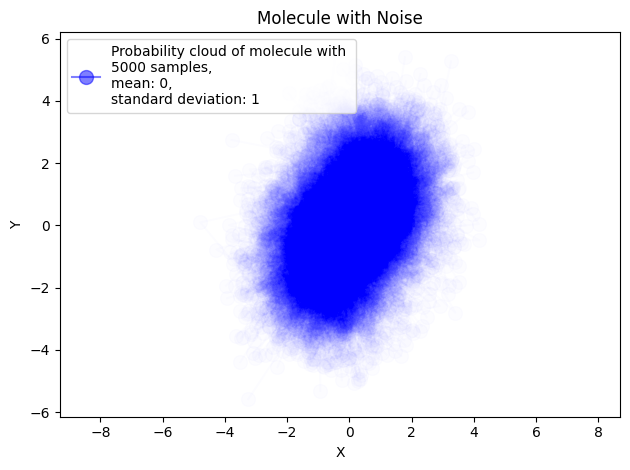

In [607]:
plot_mollies(noised_molecules)

## 1.2 Featurization

Here's an example of how to use pdist:

In [608]:
distances = pdist(molecule)
distances2 = [np.array([np.linalg.norm(mol[i] - mol[j]) for i in range(n_atoms) for j in range(i + 1, n_atoms)]) for mol in noised_molecules]
distances

array([1.524548  , 2.54106427, 3.90343364, 1.52502927, 2.54106427,
       1.524548  ])

We can check that these distances are correct:

In [609]:
# Distance atom 0 - 1
print(f"{np.linalg.norm(molecule[0,:] - molecule[1,:]):.6f}")
# Distance atom 0 - 2
print(f"{np.linalg.norm(molecule[0,:] - molecule[2,:]):.6f}")
# Distance atom 0 - 3
print(f"{np.linalg.norm(molecule[0,:] - molecule[3,:]):.6f}")
# Distance atom 1 - 2
print(f"{np.linalg.norm(molecule[1,:] - molecule[2,:]):.6f}")
# Distance atom 1 - 3
print(f"{np.linalg.norm(molecule[1,:] - molecule[3,:]):.6f}")
# Distance atom 2 - 3
print(f"{np.linalg.norm(molecule[2,:] - molecule[3,:]):.6f}")


1.524548
2.541064
3.903434
1.525029
2.541064
1.524548


In [610]:
flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in noised_molecules]
distances = [pdist(mol) for mol in noised_molecules]
potentials = [(1 / dist) for dist in distances]
total_energies = [sum(potential) for potential in potentials]
# potentials
# distances
total_energies

[2.988518251744381,
 2.1555071659624647,
 3.6749727522775535,
 2.881549663875318,
 2.2840029170432548,
 2.6575535609414294,
 1.9913732945353741,
 2.1376359207727287,
 4.931735245384681,
 2.457628450243824,
 2.6377129262608596,
 4.048067397528621,
 2.025461851056739,
 2.72353568388532,
 1.7514451551832901,
 4.953472802804763,
 5.131844320570197,
 5.183550732549184,
 2.6366742196018906,
 3.0666494806628735,
 4.953804558866945,
 2.1138572042787276,
 2.317282260475423,
 4.211974283042861,
 3.245720537830214,
 2.368359939639371,
 3.4895129436152876,
 4.465412688722191,
 3.0982221638817293,
 3.0612622215913756,
 12.328900451851784,
 6.6698071308116,
 2.235573926884695,
 3.6536671042700304,
 2.0328190195519693,
 2.3458423644258657,
 1.7991652140082146,
 2.0423325061625914,
 2.709025701469015,
 2.953631539771462,
 2.6262420140909093,
 1.786839078317548,
 4.027893594367389,
 4.8863600400703655,
 2.048772831768318,
 2.5756733272591257,
 9.130483178132334,
 2.645431759315548,
 3.8389053671751143,

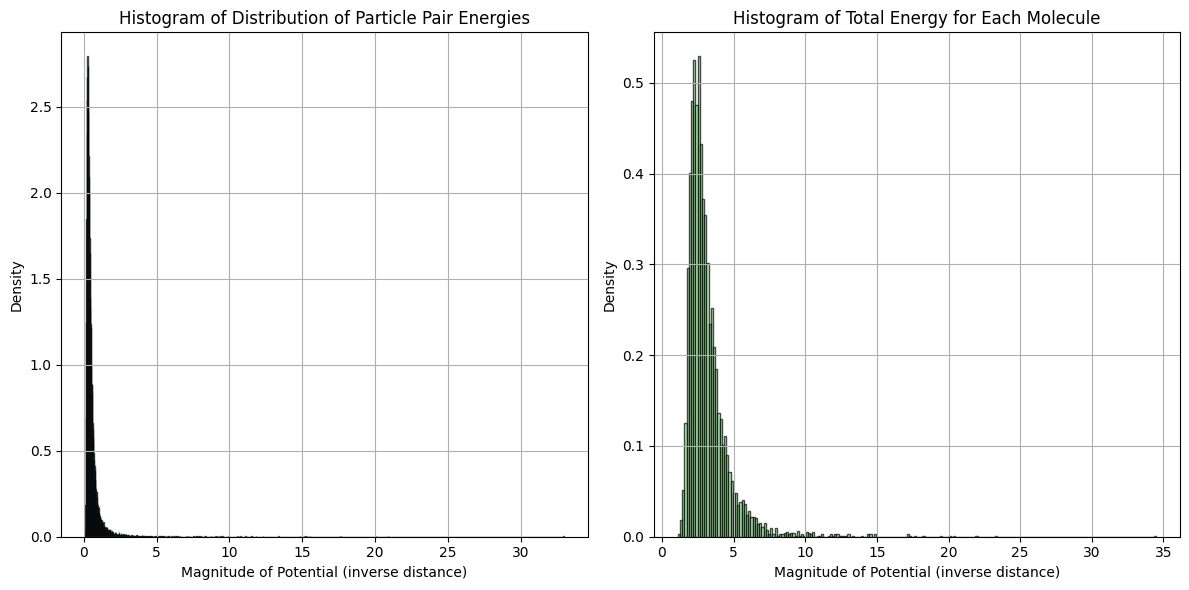

In [611]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

pairwise_energies = np.concatenate(potentials)

ax[0].hist(pairwise_energies, bins='auto', density=True, color='skyblue', edgecolor='black', alpha=0.7)
ax[0].set_title("Histogram of Distribution of Particle Pair Energies")
ax[0].set_xlabel("Magnitude of Potential (inverse distance)")
ax[0].set_ylabel("Density")
ax[0].grid(True)

ax[1].hist(total_energies, bins='auto', density=True, color='lightgreen', edgecolor='black', alpha=0.7)
ax[1].set_title("Histogram of Total Energy for Each Molecule")
ax[1].set_xlabel("Magnitude of Potential (inverse distance)")
ax[1].set_ylabel("Density")
ax[1].grid(True)

plt.tight_layout()
plt.show()



In [612]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self) -> int:
    return self.len

In [613]:
train_fraction = .8
n_train = int(train_fraction * n_samples)

ids = np.arange(n_samples)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))

flattened_coordinates = np.array(flattened_coordinates)
total_energies = np.array(total_energies)
distances = np.array(distances)

coords_train_data = Data(flattened_coordinates[ids_train], total_energies[ids_train])
coords_test_data = Data(flattened_coordinates[ids_test], total_energies[ids_test])
dists_train_data = Data(distances[ids_train], total_energies[ids_train])
dists_test_data = Data(distances[ids_test], total_energies[ids_test])

In [614]:
distances[ids_train].shape

(4000, 6)

In [615]:
batch_size = 128
coords_train_loader = DataLoader(coords_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
coord_test_loader = DataLoader(coords_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

dists_train_loader = DataLoader(dists_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
dists_test_loader = DataLoader(dists_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

In [616]:
# import torch
# import torch.nn as nn

# import torch.nn.functional as F
# from torch.utils.data import DataLoader, TensorDataset

class MLPPotentialEstimator(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLPPotentialEstimator, self).__init__()
        
        layers = []
        in_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ELU(alpha=1.0))  
            in_size = hidden_size
        
        layers.append(nn.Linear(in_size, output_size))
        
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    """
    Function to train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training data.
        criterion: The loss function (e.g., MSELoss).
        optimizer: The optimizer to update weights (e.g., Adam).
        num_epochs: The number of epochs to train.
    """
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()  

        for inputs, labels in train_loader:
            optimizer.zero_grad()  
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        train_losses.append(epoch_loss)
    
        model.eval() 
        with torch.no_grad(): 
            test_loss = 0.0
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
            
            avg_test_loss = test_loss / len(test_loader)
            print(f"Test Loss: {avg_test_loss:.4f}")
            test_losses.append(test_loss)

        model.train() 

    return train_losses, test_losses


def evaluate_regression_model(model, dataloader, criterion, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        model.to(device)
        model.eval() 

        total_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():  
            for batch in dataloader:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                all_preds.extend(outputs.cpu().detach().numpy().flatten())  # Flatten output
                all_labels.extend(labels.cpu().detach().numpy().flatten())  # Flatten labels


        # print(type(all_preds))
        # all_preds = np.array(all_preds)
        # all_labels = np.array(all_labels)

        # # Ensure correct data types
        # all_preds = all_preds.astype(np.float64)
        # all_labels = all_labels.astype(np.float64)

        # # Check for NaN or infinite values
        # if np.any(np.isnan(all_preds)) or np.any(np.isnan(all_labels)):
        #     print("NaN values found in predictions or labels.")
        # if np.any(np.isinf(all_preds)) or np.any(np.isinf(all_labels)):
        #     print("Infinite values found in predictions or labels.")

        #  # Debugging the shapes and types
        # print(f"Shape of all_preds: {all_preds.shape}")
        # print(f"Shape of all_labels: {all_labels.shape}")
        # print(f"Type of all_preds: {type(all_preds)}")
        # print(f"Type of all_labels: {type(all_labels)}")

        # Compute metrics
        avg_loss = total_loss / len(dataloader)
        mse = mean_squared_error(all_labels, all_preds)
        mae = mean_absolute_error(all_labels, all_preds)
        r2 = r2_score(all_labels, all_preds)

        return {
            "loss": avg_loss,
            "mse": mse,
            "mae": mae,
            "r2": r2,
        }
    
# def plot_regression_model(model,)
        

In [617]:
mean_squared_error(np.array([1, 2, 3]), np.array([4, 5, 6]))

9.0

In [619]:
coords_input_size = 8  #
dists_input_size = 6
hidden_sizes = [60, 60, 60, 60, 60, 60] 
output_size = 1  

coords_model = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
dists_model = MLPPotentialEstimator(dists_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
coords_optimizer = optim.Adam(coords_model.parameters(), lr=0.001)
dists_optimizer = optim.Adam(dists_model.parameters(), lr=.001)
scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)






/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [620]:
list(coords_model.parameters())

[Parameter containing:
 tensor([[-2.0943e-01, -4.3962e-02,  1.4440e-01, -6.5280e-02, -6.5673e-02,
          -1.7094e-01,  5.0431e-02,  2.9241e-01],
         [ 1.2481e-02, -1.4545e-02, -2.2070e-01,  1.0820e-01,  2.0614e-01,
           1.8884e-01, -2.1302e-01, -2.5207e-01],
         [ 3.5077e-01, -2.9566e-01, -1.9727e-01, -1.9170e-01,  1.9613e-01,
          -1.3016e-01, -3.4347e-01,  1.8136e-02],
         [ 3.9880e-02,  5.0936e-02,  7.2091e-02,  2.3449e-01,  2.0121e-01,
          -7.6457e-02,  1.2591e-01,  2.0168e-01],
         [ 8.1187e-02, -2.9404e-01, -3.1449e-01,  2.2454e-02, -2.6975e-01,
          -8.8927e-02, -1.7249e-01,  1.5464e-01],
         [ 3.3798e-01, -9.1437e-02, -1.0849e-01,  1.1895e-01, -7.7267e-02,
          -2.9634e-01, -6.0381e-02, -2.9757e-01],
         [ 4.9076e-02, -6.7786e-02,  1.4866e-01,  7.2334e-02,  1.7378e-01,
           2.0760e-01, -1.9225e-01,  1.9902e-01],
         [-1.9513e-01,  1.4654e-01, -3.0035e-01,  1.6574e-01, -1.3981e-01,
           3.2721e-01, -2.1

In [621]:
num_epochs = 500
coords_train_losses, coords_test_losses = train_model(coords_model, coords_train_loader, coord_test_loader, criterion, coords_optimizer, num_epochs)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/500], Loss: 6.2387
Test Loss: 3.1191
Epoch [2/500], Loss: 2.9835
Test Loss: 2.8422
Epoch [3/500], Loss: 2.9381
Test Loss: 2.8281
Epoch [4/500], Loss: 2.9424
Test Loss: 2.7693
Epoch [5/500], Loss: 2.7837
Test Loss: 2.7752
Epoch [6/500], Loss: 2.8270
Test Loss: 2.8318
Epoch [7/500], Loss: 2.7869
Test Loss: 2.7417
Epoch [8/500], Loss: 2.7845
Test Loss: 2.7696
Epoch [9/500], Loss: 2.7832
Test Loss: 2.7896
Epoch [10/500], Loss: 2.8058
Test Loss: 2.7395
Epoch [11/500], Loss: 2.7745
Test Loss: 2.7876
Epoch [12/500], Loss: 2.7819
Test Loss: 2.7540
Epoch [13/500], Loss: 2.7792
Test Loss: 2.7822
Epoch [14/500], Loss: 3.2191
Test Loss: 2.7953
Epoch [15/500], Loss: 2.8108
Test Loss: 2.7740
Epoch [16/500], Loss: 2.8151
Test Loss: 2.7822
Epoch [17/500], Loss: 2.8036
Test Loss: 2.7796
Epoch [18/500], Loss: 2.7760
Test Loss: 2.7627
Epoch [19/500], Loss: 2.8019
Test Loss: 2.7794
Epoch [20/500], Loss: 2.8043
Test Loss: 2.7892
Epoch [21/500], Loss: 2.9873
Test Loss: 2.7406
Epoch [22/500], Loss: 

In [622]:
dists_num_epochs = 50
dists_train_losses, dists_test_losses = train_model(dists_model, dists_train_loader, dists_test_loader, dists_criterion, dists_optimizer, dists_num_epochs)


Epoch [1/500], Loss: 5.1295
Test Loss: 3.0383
Epoch [2/500], Loss: 2.8333
Test Loss: 2.7955
Epoch [3/500], Loss: 2.7950
Test Loss: 2.8116
Epoch [4/500], Loss: 3.5254
Test Loss: 2.8174
Epoch [5/500], Loss: 2.7949
Test Loss: 2.7842
Epoch [6/500], Loss: 2.7944
Test Loss: 2.7566
Epoch [7/500], Loss: 2.8232
Test Loss: 2.7828
Epoch [8/500], Loss: 2.7755
Test Loss: 2.8382
Epoch [9/500], Loss: 2.8842
Test Loss: 2.7624
Epoch [10/500], Loss: 2.8132
Test Loss: 2.7941
Epoch [11/500], Loss: 2.8420
Test Loss: 2.7936
Epoch [12/500], Loss: 2.8355
Test Loss: 2.7564
Epoch [13/500], Loss: 2.9314
Test Loss: 2.7706
Epoch [14/500], Loss: 2.9933
Test Loss: 2.7642
Epoch [15/500], Loss: 2.7778
Test Loss: 2.8005
Epoch [16/500], Loss: 2.8121
Test Loss: 2.7856
Epoch [17/500], Loss: 2.7862
Test Loss: 2.7956
Epoch [18/500], Loss: 2.7937
Test Loss: 2.8377
Epoch [19/500], Loss: 2.8829
Test Loss: 2.8203
Epoch [20/500], Loss: 2.7696
Test Loss: 2.7601
Epoch [21/500], Loss: 2.8039
Test Loss: 2.7896
Epoch [22/500], Loss: 

In [ ]:
# distances

In [ ]:
# dists_test_losses

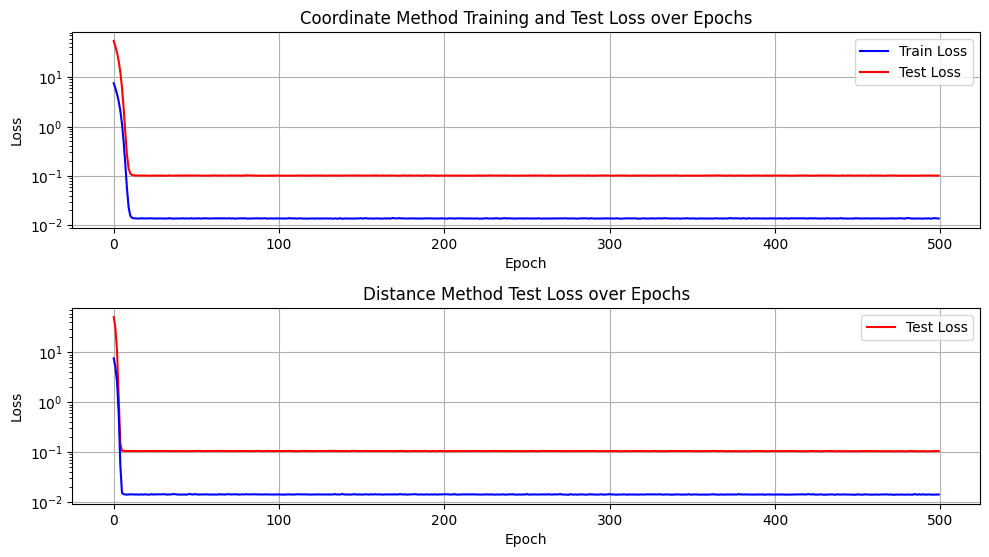

In [ ]:
plt.figure(figsize=(10, 8))

# First subplot (top)
plt.subplot(3, 1, 1)  
plt.plot(range(len(coords_train_losses)), coords_train_losses, label="Train Loss", color="blue")
plt.plot(range(len(coords_test_losses)), coords_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Coordinate Method Training and Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_test_losses)), dists_test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Distance Method Test Loss over Epochs")
plt.legend()
plt.yscale('log')
plt.grid(True)

# plt.subplot(3, 1, 3)  # 2 rows, 1 column, second subplot
plt.plot(range(len(dists_train_losses)), dists_train_losses, label="Train Loss", color="blue")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Distance Method Training Loss over Epochs")
# plt.legend()
# plt.yscale('log')
# plt.grid(True)


plt.tight_layout()

plt.show()

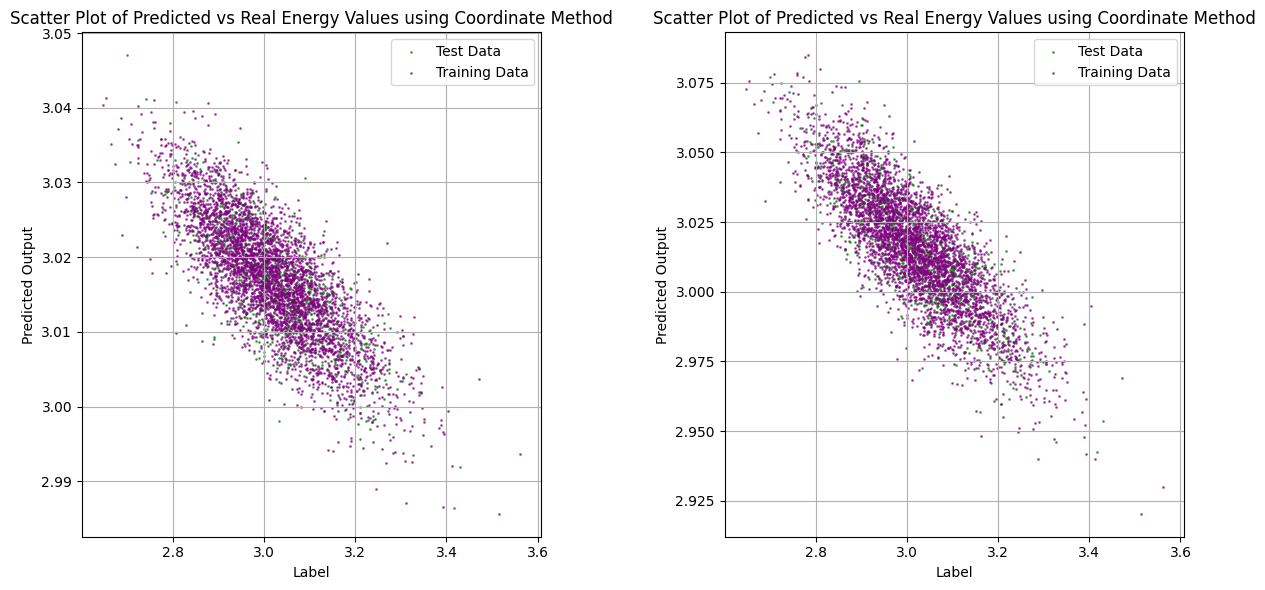

In [ ]:
with torch.no_grad():
  coords_test_pred = []
  coords_test_real = []
  coords_train_pred = []
  coords_train_real = []

  dists_test_pred = []
  dists_test_real = []
  dists_train_pred = []
  dists_train_real = []

  for inputs, label in coords_test_data:
    output = coords_model(inputs)
    coords_test_pred.append(output) 
    coords_test_real.append(label)

  for inputs, label in coords_train_data:
    output = coords_model(inputs)
    coords_train_pred.append(output) 
    coords_train_real.append(label)
  
  for inputs, label in dists_test_data:
    output = dists_model(inputs)
    dists_test_pred.append(output) 
    dists_test_real.append(label)

  for inputs, label in dists_train_data:
    output = dists_model(inputs)
    dists_train_pred.append(output) 
    dists_train_real.append(label)
    
  # print(len(coords_input))
  # print(len(coords_test_pred))

  # len(coords_test_data)
  # coords_test_data[0]

  # test_coords = coords_test_data[:,0]
  # test_labels = coords_test_data[:,1]
  # train_coords = coords_train_data[:,0]
  # train_labels = coords_train_data[:,1] 

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  # 1 row, 2 columns
  ax1, ax2 = axes
  # plt.figure(figsize=(10, 6))

  # Scatter plot for predicted values
  ax1.scatter(coords_test_real, coords_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax1.scatter(coords_train_real, coords_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax1.set_xlabel('Label')
  ax1.set_ylabel('Predicted Output')
  ax1.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')

  ax2.scatter(dists_test_real, dists_test_pred, color='green', alpha=0.6, label='Test Data', s=1)
  ax2.scatter(dists_train_real, dists_train_pred, color='purple', alpha=0.6, label='Training Data', s=1)

  # Add labels and title
  ax2.set_xlabel('Label')
  ax2.set_ylabel('Predicted Output')
  ax2.set_title('Scatter Plot of Predicted vs Real Energy Values using Coordinate Method')


  ax1.legend()
  ax2.legend()

  plt.tight_layout()

  # Show grid for better readability
  ax1.grid()
  ax2.grid()
  fig.subplots_adjust(wspace=0.4, hspace=0.6)

  # Display the plot
  plt.show()

In [ ]:
evaluate_regression_model(coords_model, coord_test_loader, criterion)



{'loss': 0.012690907111391425,
 'mse': 0.014020049,
 'mae': 0.09461973,
 'r2': -0.11947485941666858}

In [ ]:
for inputs, label in dists_test_data:
  output = dists_model(inputs)
  print(output)
  dists_test_pred.append(output) 
  dists_test_real.append(label)

# for inputs, label in dists_train_data:
#   output = dists_model(inputs)
#   dists_train_pred.append(output) 
#   dists_train_real.append(label)

tensor([3.0188], grad_fn=<ViewBackward0>)
tensor([3.0182], grad_fn=<ViewBackward0>)
tensor([3.0191], grad_fn=<ViewBackward0>)
tensor([2.9902], grad_fn=<ViewBackward0>)
tensor([3.0199], grad_fn=<ViewBackward0>)
tensor([3.0216], grad_fn=<ViewBackward0>)
tensor([3.0086], grad_fn=<ViewBackward0>)
tensor([3.0192], grad_fn=<ViewBackward0>)
tensor([3.0202], grad_fn=<ViewBackward0>)
tensor([3.0255], grad_fn=<ViewBackward0>)
tensor([3.0096], grad_fn=<ViewBackward0>)
tensor([3.0205], grad_fn=<ViewBackward0>)
tensor([3.0148], grad_fn=<ViewBackward0>)
tensor([3.0315], grad_fn=<ViewBackward0>)
tensor([3.0530], grad_fn=<ViewBackward0>)
tensor([3.0182], grad_fn=<ViewBackward0>)
tensor([3.0303], grad_fn=<ViewBackward0>)
tensor([3.0089], grad_fn=<ViewBackward0>)
tensor([3.0376], grad_fn=<ViewBackward0>)
tensor([3.0025], grad_fn=<ViewBackward0>)
tensor([2.9898], grad_fn=<ViewBackward0>)
tensor([3.0280], grad_fn=<ViewBackward0>)
tensor([3.0585], grad_fn=<ViewBackward0>)
tensor([3.0140], grad_fn=<ViewBack

## 2 Data augmenatation

You can use this function to rotate the samples in your dataset.

In [ ]:
def rotate(vector, theta):
    """Rotates a two-dimensional vector by the angle theta."""
    rotMatrix = np.array(
        [[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]
    )
    return np.matmul(rotMatrix, vector)

This is how you can permute data:

In [ ]:
ids = [1,2,3,0]
molecule_permuted = molecule[ids,:]

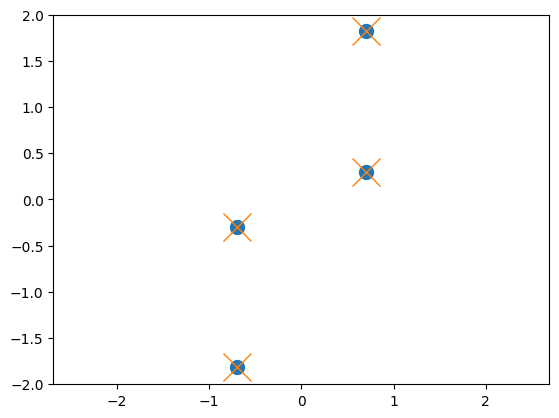

In [ ]:
plt.plot(molecule[:, 0], molecule[:, 1], "o", markersize=10)
plt.axis("equal")
plt.plot(molecule_permuted[:, 0], molecule_permuted[:, 1], "x", markersize=20)
plt.axis("equal")

plt.show()

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


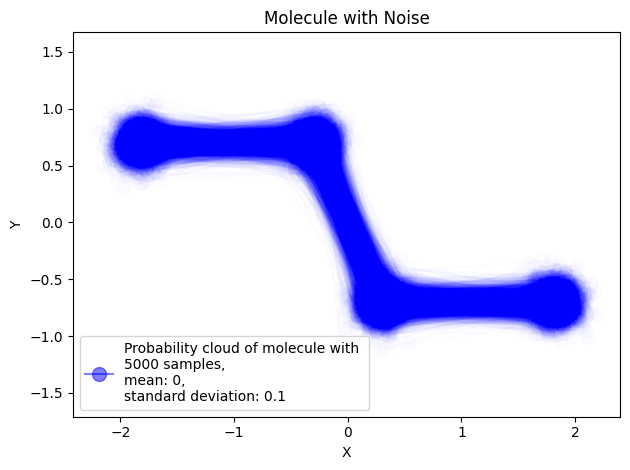

In [ ]:
rotated_noised_molecules = [np.transpose(rotate(np.transpose(molly), np.pi / 2)) for molly in noised_molecules]
plot_mollies(rotated_noised_molecules, "Rotated Molecule with Noise")

# noised_molecules[0]

In [ ]:
def permute_without_fixed_points(coords):
    n = len(coords)
    while True:
        perm = torch.randperm(n)  # Generate random permutation of indices
        if not torch.all(perm == torch.arange(n)):  # Check for no fixed points
            return coords[perm]  # Apply permutation to the tensor

In [ ]:
rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in rotated_noised_molecules]
rotated_distances = [pdist(mol) for mol in noised_molecules]
rotated_potentials = [(1 / dist) for dist in rotated_distances]
rotated_total_energies = [sum(potential) for potential in rotated_potentials]

permutated_rotated_noised_molecules = [permute_without_fixed_points(molly) for molly in rotated_noised_molecules]
permutated_rotated_flattened_coordinates = [np.reshape(mol, (n_atoms*n_dimensions)) for mol in permutated_rotated_noised_molecules]
permutated_rotated_distances = [permute_without_fixed_points(molly) for molly in rotated_distances]

rotated_coords_data = Data(flattened_coordinates, total_energies)
rotated_dists_data = Data(distances, total_energies)
permutated_rotated_coords_data = Data(np.array(permutated_rotated_flattened_coordinates), total_energies)
permutated_rotated_dists_data = Data(np.array(permutated_rotated_distances), total_energies)

batch_size = 128
rotated_coords_loader = DataLoader(rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

rotated_dists_loader = DataLoader(rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_coords_loader = DataLoader(permutated_rotated_coords_data, 
                         batch_size=batch_size, 
                         shuffle=True)

permutated_rotated_dists_loader = DataLoader(permutated_rotated_dists_data, 
                         batch_size=batch_size, 
                         shuffle=True)

print("Rotated coords model: ", evaluate_regression_model(coords_model, rotated_coords_loader, criterion))
print("Rotated distances model: ", evaluate_regression_model(dists_model, rotated_dists_loader, criterion))

print("Permutated rotated coords model: ", evaluate_regression_model(coords_model, permutated_rotated_coords_loader, criterion))
print("Permutated rotated distances model: ", evaluate_regression_model(dists_model, permutated_rotated_dists_loader, criterion))


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

Rotated coords model:  {'loss': 0.013436150900088251, 'mse': 0.014970473, 'mae': 0.09727034, 'r2': -0.11246078597384046}
Rotated distances model:  {'loss': 0.013932472444139421, 'mse': 0.01798084, 'mae': 0.1065229, 'r2': -0.33616214240910014}
Permutated rotated coords model:  {'loss': 0.12783678006380797, 'mse': 0.12824163, 'mae': 0.33048046, 'r2': -8.529677873748229}
Permutated rotated distances model:  {'loss': 0.040204463293775916, 'mse': 0.04511247, 'mae': 0.17106307, 'r2': -2.352322558043376}


/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/

In [ ]:
# permutated_rotated_noised_molecules

/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_75846/1935090512.py:23: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


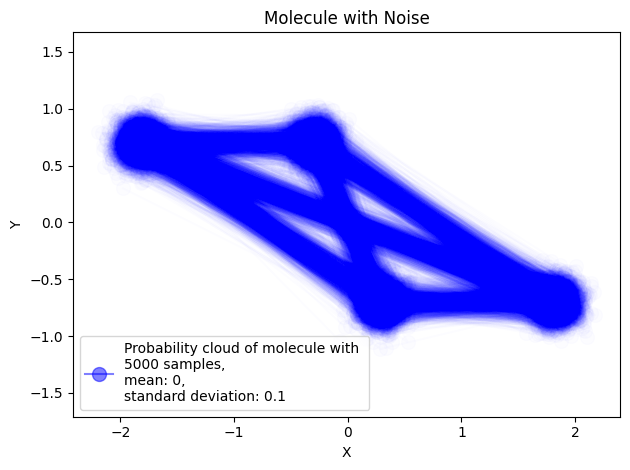

In [ ]:

plot_mollies(permutated_rotated_noised_molecules, "Permutated and Rotated Molecules with Noise")
# permutated_rotated_noised_molecules

In [ ]:
# 2.3

augmented_coords1 = np.vstack((rotated_flattened_coordinates, flattened_coordinates))
permutated_coords_without_rotating = [np.reshape(permute_without_fixed_points(molly), (n_atoms*n_dimensions)) for molly in noised_molecules]
augmented_coords2 = np.vstack((flattened_coordinates, permutated_coords_without_rotating))

# print(augmented_coords1)
# print(augmented_coords2)

def get_dists_from_flattened(mol):
  x1, y1, x2, y2, x3, y3, x4, y4 = mol
  d12 = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** .5
  d13 = ((x1 - x3) ** 2 + (y1 - y3) ** 2) ** .5
  d14 = ((x1 - x4) ** 2 + (y1 - y4) ** 2) ** .5
  d23 = ((x2 - x3) ** 2 + (y2 - y3) ** 2) ** .5
  d24 = ((x2 - x4) ** 2 + (y2 - y4) ** 2) ** .5
  d34 = ((x3 - x4) ** 2 + (y3 - y4) ** 2) ** .5
  rtn = [d12, d13, d14, d23, d24, d34]
  return rtn


augmented_distances1 = [get_dists_from_flattened(mol) for mol in augmented_coords1]
augmented_potentials1 = [(1 / dist) for dist in augmented_coords1]
augmented_total_energies1 = np.array([sum(potential) for potential in augmented_potentials1])

augmented_distances2 = np.array([get_dists_from_flattened(mol) for mol in augmented_coords2])
augmented_potentials2 = [(1 / dist) for dist in augmented_coords2]
augmented_total_energies2 = np.array([sum(potential) for potential in augmented_potentials2])

train_fraction = .8
n_train = int(train_fraction * n_samples * 2)

ids = np.arange(n_samples * 2)
print(ids)
np.random.shuffle(ids)
ids_train, ids_test  = map(np.array, np.split(ids, [n_train]))
ids_train = np.array(ids_train)
ids_test = np.array(ids_test)

print(ids_train)
print(ids_test)

aug1_train_data = Data(augmented_coords1[ids_train], augmented_total_energies1[ids_train])
aug1_test_data = Data(augmented_coords1[ids_test], augmented_total_energies1[ids_test])
aug2_train_data = Data(augmented_coords2[ids_train], augmented_total_energies2[ids_train])
aug2_test_data = Data(augmented_coords2[ids_test], augmented_total_energies2[ids_test])

batch_size = 128
aug1_train_loader = DataLoader(aug1_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
aug1_test_loader = DataLoader(aug1_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

aug2_train_loader = DataLoader(aug2_train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
aug2_test_loader = DataLoader(aug2_test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

# coords_input_size = 8  # Example input size (number of features)
# dists_input_size = 6
# hidden_sizes = [128, 128, 128, 128, 128, 64, 64, 32]  # Number of neurons per hidden layer
# output_size = 1  # Single output (potential energy)

augmented_model1 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)
augmented_model2 = MLPPotentialEstimator(coords_input_size, hidden_sizes, output_size)


criterion = nn.MSELoss()
dists_criterion = nn.MSELoss()
augmented_optimizer1 = optim.SGD(augmented_model1.parameters(), lr=0.001)
augmented_optimizer2 = optim.SGD(augmented_model2.parameters(), lr=.001)
# scheduler = ReduceLROnPlateau(coords_optimizer, 'min', patience=5, factor=0.5, verbose=True)

# original_and_rotated_coords


[   0    1    2 ... 9997 9998 9999]
[2736  940 4294 ...  516 3082 2742]
[6137 4433 5446 ... 2797 8153 6700]


In [ ]:
num_epochs = 50
augmented_coords_train_losses, coords_test_losses = train_model(augmented_model1, aug1_train_loader, aug1_test_loader, criterion, augmented_optimizer1, num_epochs)

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

Epoch [1/50], Loss: 59.0405
Test Loss: 183.6944
Epoch [2/50], Loss: 58.9616
Test Loss: 184.1320
Epoch [3/50], Loss: 59.0658
Test Loss: 225.1768
Epoch [4/50], Loss: 58.9762
Test Loss: 183.5482
Epoch [5/50], Loss: 59.4008
Test Loss: 183.5995
Epoch [6/50], Loss: 59.8893
Test Loss: 225.3819
Epoch [7/50], Loss: 61.7122
Test Loss: 183.4669
Epoch [8/50], Loss: 59.3743
Test Loss: 184.2895
Epoch [9/50], Loss: 59.7166
Test Loss: 183.8163
Epoch [10/50], Loss: 58.9444
Test Loss: 183.8815
Epoch [11/50], Loss: 59.3069
Test Loss: 184.1862
Epoch [12/50], Loss: 58.9630
Test Loss: 183.5651
Epoch [13/50], Loss: 59.7176
Test Loss: 186.2284
Epoch [14/50], Loss: 59.1408
Test Loss: 183.5322
Epoch [15/50], Loss: 58.9592
Test Loss: 183.5392
Epoch [16/50], Loss: 58.9744
Test Loss: 195.2596
Epoch [17/50], Loss: 59.0609
Test Loss: 183.7766
Epoch [18/50], Loss: 59.4484
Test Loss: 183.4659
Epoch [19/50], Loss: 61.4159
Test Loss: 183.6335
Epoch [20/50], Loss: 58.9939
Test Loss: 183.5542
Epoch [21/50], Loss: 59.5309


In [ ]:
num_epochs = 50
aug1_train_losses, aug2_test_losses = train_model(augmented_model2, aug2_train_loader, aug2_test_loader, criterion, augmented_optimizer2, num_epochs)

Epoch [1/50], Loss: 58.8777
Test Loss: 183.8976
Epoch [2/50], Loss: 58.8670
Test Loss: 184.0430
Epoch [3/50], Loss: 58.9280
Test Loss: 184.3556
Epoch [4/50], Loss: 58.9070
Test Loss: 184.0730
Epoch [5/50], Loss: 58.8653
Test Loss: 183.7723
Epoch [6/50], Loss: 62.8250
Test Loss: 183.9239
Epoch [7/50], Loss: 58.8943
Test Loss: 225.8131
Epoch [8/50], Loss: 59.0808
Test Loss: 184.5371
Epoch [9/50], Loss: 63.0741
Test Loss: 183.8924
Epoch [10/50], Loss: 58.8906
Test Loss: 225.6384
Epoch [11/50], Loss: 59.3290
Test Loss: 184.4940
Epoch [12/50], Loss: 58.8647
Test Loss: 184.5123
Epoch [13/50], Loss: 58.8413
Test Loss: 183.7853
Epoch [14/50], Loss: 58.8667
Test Loss: 183.9850
Epoch [15/50], Loss: 58.9139
Test Loss: 183.9751
Epoch [16/50], Loss: 58.8783
Test Loss: 183.7873
Epoch [17/50], Loss: 58.8947
Test Loss: 184.4859
Epoch [18/50], Loss: 58.8577
Test Loss: 184.5532
Epoch [19/50], Loss: 58.9064
Test Loss: 184.2725
Epoch [20/50], Loss: 58.9974
Test Loss: 184.0649
Epoch [21/50], Loss: 59.6776


In [ ]:
print(evaluate_regression_model(augmented_model1, aug1_test_loader, criterion))
print(evaluate_regression_model(augmented_model2, aug2_test_loader, criterion))

/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rockykamenrubio/Documents/freie_universitat/molecular_simulations/molecular_simulations_env/lib/python3.12/site-packages/torc

{'loss': 183.67415672540665, 'mse': 187.7601, 'mae': 2.6115797, 'r2': -0.00019935300443130188}
{'loss': 183.95169153809547, 'mse': 188.07285, 'mae': 2.6182275, 'r2': -0.0014077513990713442}
